Epoch 1/5
203/203 [==============================] - 35s 163ms/step - loss: 0.8031 - mae: 0.5736 - val_loss: 1.4196 - val_mae: 0.6470
Epoch 2/5
203/203 [==============================] - 34s 169ms/step - loss: 0.2178 - mae: 0.2856 - val_loss: 2.0700 - val_mae: 0.7812
Epoch 3/5
203/203 [==============================] - 33s 164ms/step - loss: 0.1599 - mae: 0.2530 - val_loss: 1.9433 - val_mae: 0.7590
Epoch 4/5
203/203 [==============================] - 34s 169ms/step - loss: 0.1278 - mae: 0.2311 - val_loss: 1.8527 - val_mae: 0.7324
Epoch 5/5
151/151 [==============================] - 4s 29ms/step - loss: 1.6395 - mae: 0.6886
Validation Loss: 1.6395337581634521, Validation MAE: 0.6885619163513184


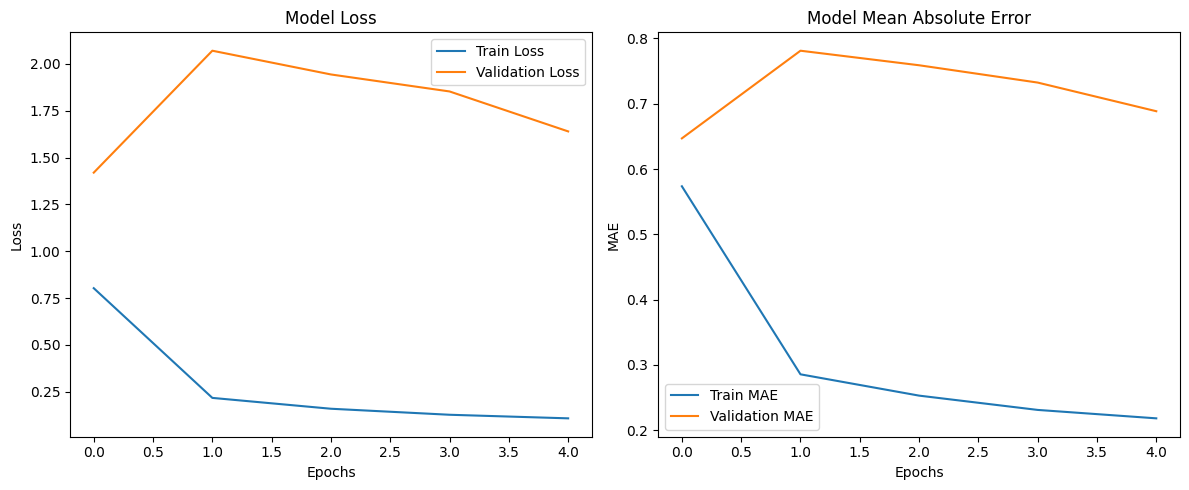

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 316ms/step
Predicted Score: 3.5218422


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import pickle

# Load the datasets
train_path = '/content/training_set_rel3.xls'
valid_path = '/content/valid_set.xls'

train_df = pd.read_excel(train_path)
valid_df = pd.read_excel(valid_path)

# Assigning essay texts and scores from the columns
train_essays = train_df['essay'].astype(str)
train_scores = train_df['domain1_score'].astype(float)
valid_essays = valid_df['essay'].astype(str)
valid_scores = valid_df['score'].astype(float)

# Handle NaN values in scores
train_scores.fillna(train_scores.mean(), inplace=True)
valid_scores.fillna(valid_scores.mean(), inplace=True)

# Tokenize and pad the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_essays)

train_sequences = tokenizer.texts_to_sequences(train_essays)
train_padded = pad_sequences(train_sequences, maxlen=300)
valid_sequences = tokenizer.texts_to_sequences(valid_essays)
valid_padded = pad_sequences(valid_sequences, maxlen=300)

# Normalize the scores
scaler = StandardScaler()
train_scores_scaled = scaler.fit_transform(train_scores.values.reshape(-1, 1)).flatten()
valid_scores_scaled = scaler.transform(valid_scores.values.reshape(-1, 1)).flatten()

# Build the neural network model
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=300),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(train_padded, train_scores_scaled,
                    epochs=5,
                    batch_size=64,
                    validation_data=(valid_padded, valid_scores_scaled),
                    verbose=1)

# Evaluate the model
loss, mae = model.evaluate(valid_padded, valid_scores_scaled)
print(f'Validation Loss: {loss}, Validation MAE: {mae}')

# Plot training and validation loss and MAE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Save the model, tokenizer, and scaler
model.save('aes_model.h5')
with open('tokenizer.pkl', 'wb') as t:
    pickle.dump(tokenizer, t)
with open('scaler.pkl', 'wb') as s:
    pickle.dump(scaler, s)

# Function to predict essay score
def predict_essay_score(essay_text):
    model = load_model('aes_model.h5')
    with open('tokenizer.pkl', 'rb') as t:
        tokenizer = pickle.load(t)
    with open('scaler.pkl', 'rb') as s:
        scaler = pickle.load(s)

    sequence = tokenizer.texts_to_sequences([essay_text])
    padded_sequence = pad_sequences(sequence, maxlen=300)
    predicted_scaled_score = model.predict(padded_sequence)
    predicted_score = scaler.inverse_transform(predicted_scaled_score)

    return predicted_score[0][0]

# Example usage
sample_essay = "Dear local newspaper: I am writing this letter to tell you I think computers have a positive effect on people..."
predicted_score = predict_essay_score(sample_essay)
print("Predicted Score:", predicted_score)
